In [3]:
import pandas as pd
import numpy as np
import random
from numpy import random
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score


data = pd.read_csv('data/result.csv', parse_dates=['time'], index_col=['time'])

# Classifying Faults using Regression Models and Virtual Sensor

# Assigning Training and Testing data

In [4]:
train_data = data.loc['2017-06-26 07:00:00':'2017-07-07 21:15:00']
test_data1 = data.loc['2017-07-09 08:00:00':'2017-07-09 18:00:00'] 
test_data2 = data.loc['2017-07-10 08:00:00':'2017-07-10 18:00:00']
test_data3 = data.loc['2017-07-11 08:00:00':'2017-07-11 18:00:00']
test_data4 = data.loc['2017-07-12 08:00:00':'2017-07-12 18:00:00']
test_data5 = data.loc['2017-07-13 08:00:00':'2017-07-13 18:00:00']
print(test_data1)

                     outdoor_temp  zone_temp  occupancy  supply_temp  air_flow
time                                                                          
2017-07-09 08:00:00     26.000000  21.595436          0    19.082426  0.377812
2017-07-09 08:05:00     26.216667  21.429414         10    17.616819  0.731824
2017-07-09 08:10:00     26.433333  21.250354         10    17.374311  0.731824
2017-07-09 08:15:00     26.650000  21.208633         10    17.456729  0.731824
2017-07-09 08:20:00     26.866667  21.245452         10    17.420510  0.731824
...                           ...        ...        ...          ...       ...
2017-07-09 17:40:00     38.333333  23.335806         10    17.921819  0.731824
2017-07-09 17:45:00     38.250000  23.372808         10    18.083601  0.731824
2017-07-09 17:50:00     38.166667  23.418935         10    18.254923  0.731824
2017-07-09 17:55:00     38.083333  23.472316         10    18.435863  0.731824
2017-07-09 18:00:00     38.000000  23.539049        

# Visualization of training data

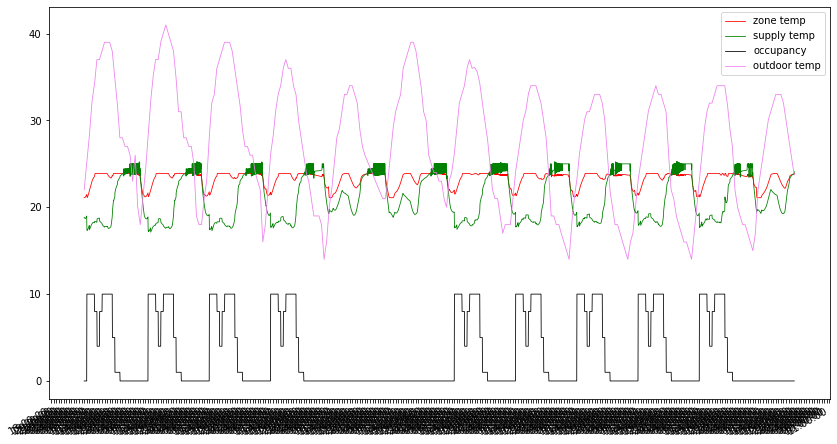

In [5]:
fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(train_data.index, train_data['zone_temp'].values, color = 'red', linewidth = 0.8, label = 'zone temp')
ax.plot(train_data.index, train_data['supply_temp'].values, color = 'green', linewidth = 0.8, label = 'supply temp')
ax.plot(train_data.index, train_data['occupancy'].values, color = 'black', linewidth = 0.8, label = 'occupancy')
ax.plot(train_data.index, train_data['outdoor_temp'].values, color = 'violet', linewidth = 0.8, label = 'outdoor temp')
#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
plt.legend()
plt.show()

# Simulating fault for regression model

In [6]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

def simulateFault(sensedValues, att, params):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index/4
    BMS = []
    true_values = []
    BMS_final = []
    classification = []
    
    noise = random.rand(len(sensedValues[att])) * 0.5

    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant'] 
            sensedValues[att][i] = noise[i] + a + sensedValues[att][i]
            classification.append(1)

        elif i > interval and i <= interval*2:
            B = params['coeff']
            sensedValues[att][i] = noise[i] + B * sensedValues[att][i]
            classification.append(1)

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            sensedValues[att][i] = a 
            classification.append(1)
            
        elif i > interval*3 and i<= interval*4:
            type_fault = random.randint(1,3)
            low_bound = params['bounds'][0]
            up_bound = params['bounds'][1]
            if type_fault == 1:
                sensedValues[att][i] = low_bound - noise[i] 
            else:
                #print(up_bound + noise[i])
                sensedValues[att][i] = up_bound + noise[i]
            classification.append(1)
        else:
            sensedValues[att][i] = sensedValues[att][i] + noise[i]
            classification.append(0)
    return sensedValues, classification


# Simulating Fault for test data

In [8]:
x = train_data[['supply_temp', 'air_flow']]
y = train_data[['zone_temp']]

for i in range(1,6):
    if i == 1:
        stuck_val = random.choice(test_data1['supply_temp'])
        test_data1, classification= simulateFault(test_data1,'supply_temp', {'constant': 2, 'coeff': 1.3, 'stuck': stuck_val, 'bounds': [14,34]})
        test_data1['classification'] = classification
        #print(test_data1)
    
    elif i == 2:
        stuck_val = random.choice(test_data2['supply_temp'])
        test_data2, classification= simulateFault(test_data2,'supply_temp', {'constant': 2, 'coeff': 1.3, 'stuck': stuck_val, 'bounds': [14,34]})
        test_data2['classification'] = classification
    
    elif i == 3:
        stuck_val = random.choice(test_data3['supply_temp'])
        test_data3, classification= simulateFault(test_data3,'supply_temp', {'constant': 2, 'coeff': 1.3, 'stuck': stuck_val, 'bounds': [14,34]})
        test_data3['classification'] = classification
    
    elif i == 4:
        stuck_val = random.choice(test_data4['supply_temp'])
        test_data4, classification= simulateFault(test_data4,'supply_temp', {'constant': 2, 'coeff': 1.3, 'stuck': stuck_val, 'bounds': [14,34]})
        test_data4['classification'] = classification
    
    elif i == 5:
        stuck_val = random.choice(test_data5['supply_temp'])
        test_data5, classification= simulateFault(test_data5,'supply_temp', {'constant': 2, 'coeff': 1.3, 'stuck': stuck_val, 'bounds': [14,34]})
        test_data5['classification'] = classification

test_data = test_data1.append(test_data2)
test_data = test_data.append(test_data3)
test_data = test_data.append(test_data4)
test_data = test_data.append(test_data5)
#test_data = test_data1
x_test = test_data[['supply_temp', 'air_flow']]
y_test = test_data[['zone_temp']]


C:\Users\renat\AppData\Local\Temp\ipykernel_12620\476583837.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensedValues[att][i] = noise[i] + a + sensedValues[att][i]
C:\Users\renat\AppData\Local\Temp\ipykernel_12620\476583837.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensedValues[att][i] = noise[i] + B * sensedValues[att][i]
C:\Users\renat\AppData\Local\Temp\ipykernel_12620\476583837.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [9]:
scaler = MinMaxScaler().fit(x)

x_train_norm = scaler.transform(x)
x_test_norm = scaler.transform(x_test)

regressor = SVR()
model = regressor.fit(x_train_norm, y)
y_pred = model.predict(x_test_norm)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
print(mse)

C:\Users\renat\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.2499432051128452
1.5623580160077724


In [10]:
upper_bound = []
lower_bound = []
upper_bound = y_pred + mse
lower_bound = y_pred - mse
bounds = y_test
bounds['upper'] = upper_bound
bounds['lower'] = lower_bound
bounds['pred'] = y_pred
bounds['classification'] = test_data['classification']

C:\Users\renat\AppData\Local\Temp\ipykernel_12620\3183825902.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bounds['upper'] = upper_bound
C:\Users\renat\AppData\Local\Temp\ipykernel_12620\3183825902.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bounds['lower'] = lower_bound
C:\Users\renat\AppData\Local\Temp\ipykernel_12620\3183825902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [11]:
tpr = []
fpr = []
j = 0
print(mse)
while j <= mse*3:
    #bounds = bounds.loc['2017-07-10 22:40:00':'2017-07-11 22:40:00']

    true_fault = []

    for i in range(0,len(bounds)):
        if bounds['zone_temp'][i] > (bounds['pred'][i] + j) or bounds['zone_temp'][i] < (bounds['pred'][i] - j):
            true_fault.append(1)
        else:
            true_fault.append(0)
    bounds['predClass'] = true_fault

    tp = 0
    fn = 0
    fp = 0
    tn = 0
    for i in range(0, len(bounds)):
        if bounds['classification'][i] == 1:
            if bounds['predClass'][i] == 1:
                tp = tp + 1
            else:
                fn = fn + 1
        else:
            if bounds['predClass'][i] == 0:
                tn = tn + 1
            else:
                fp = fp + 1

    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))
    j = j + 0.01

1.5623580160077724


<Figure size 432x288 with 0 Axes>

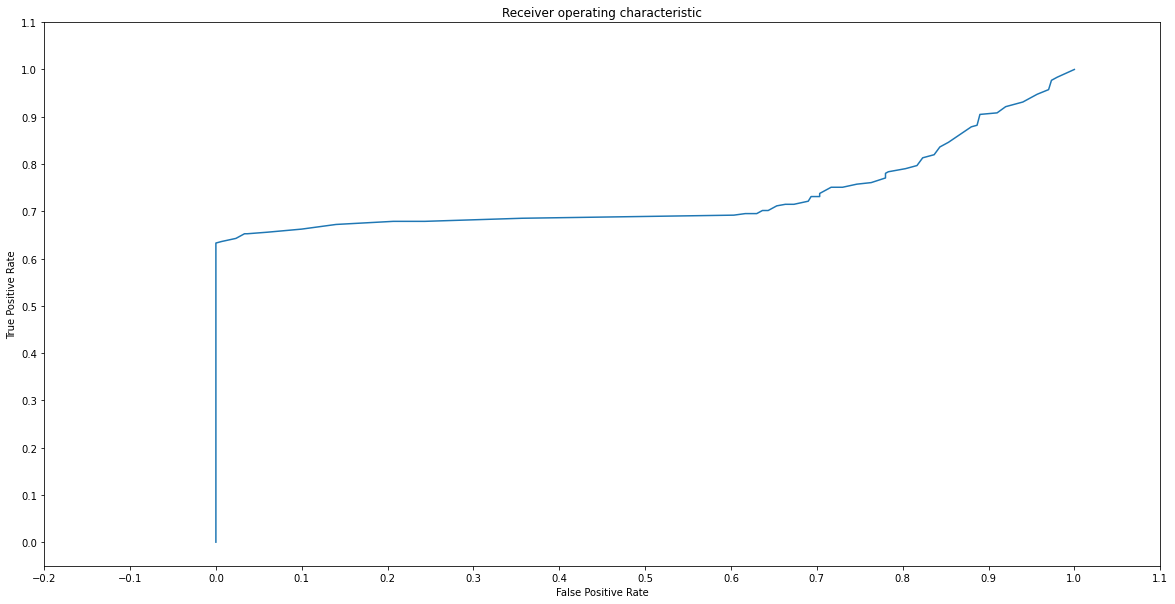

In [12]:
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(fpr, tpr)
plt.xticks(np.arange(-0.2, 1.2, step=0.1))
plt.yticks(np.arange(0, 1.2, step=0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

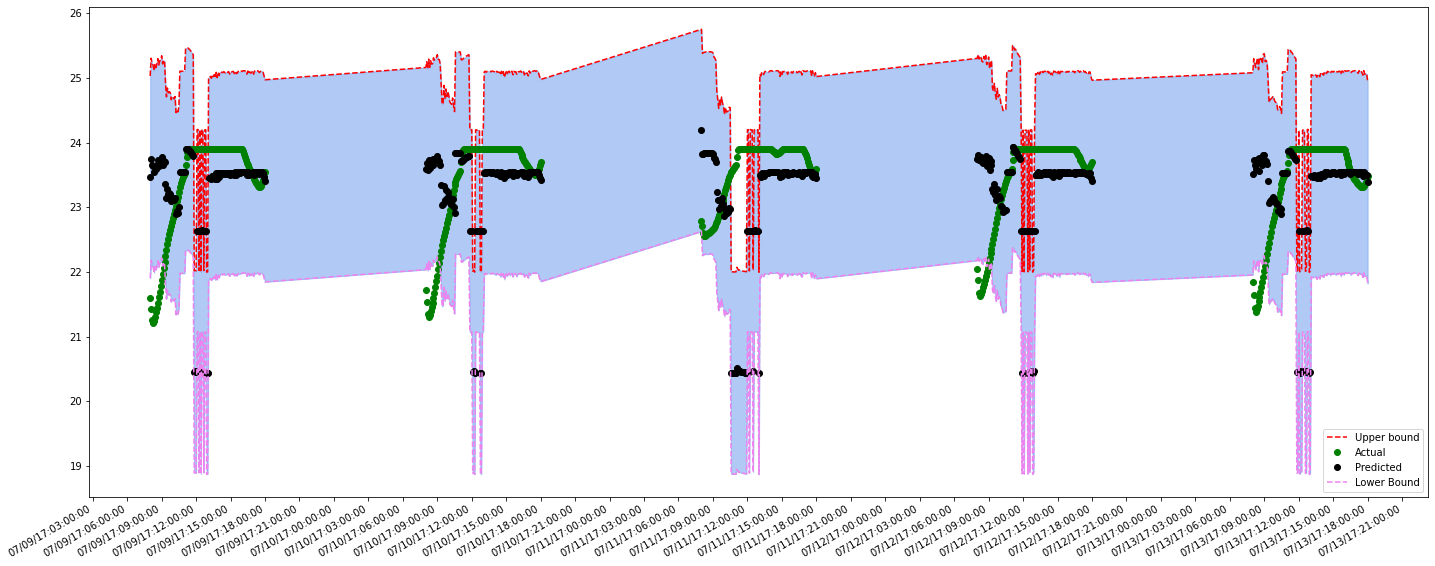

In [13]:
fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%D:%H:%M:%S')

ax.plot(bounds.index, bounds['upper'].values, '--', color = 'red', label = 'Upper bound')
ax.plot(bounds.index, bounds['zone_temp'].values, 'o', color = 'green', label = 'Actual')
ax.plot(bounds.index, bounds['pred'].values, 'o', color = 'black', label = 'Predicted')
ax.plot(bounds.index, bounds['lower'].values, '--', color = 'violet', label = 'Lower Bound')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(24, 10)
plt.fill_between(bounds.index, bounds['upper'].values,bounds['lower'].values,color='cornflowerblue',alpha=.5)
plt.legend()
plt.show()

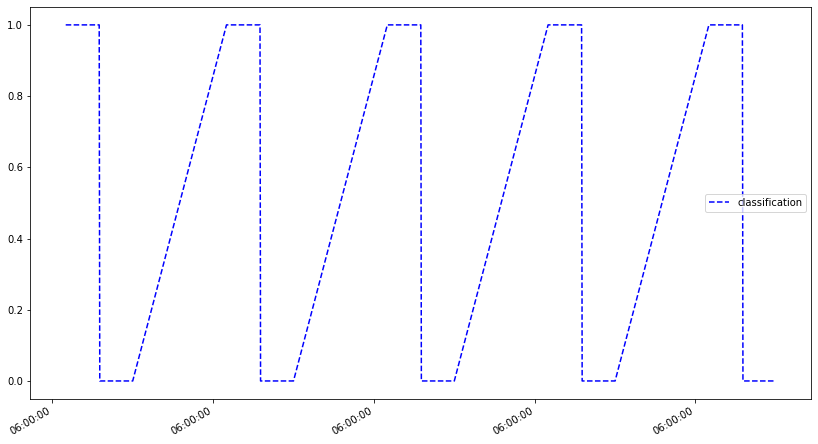

In [14]:
fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 24)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(bounds.index, bounds['classification'].values, '--', color = 'blue', label = 'classification')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
plt.legend()
plt.show()

# Classification using SVM by mathematical modelling of Faults

In [15]:
data = pd.read_csv('data/result.csv', parse_dates=['time'], index_col=['time'])

train_data = []
test_data1 = []
test_data2 = []
test_data3 = []
test_data4 = []
test_data5 = []


train_data = data.loc['2017-06-01 07:00:00':'2017-06-09 21:15:00']
test_data1 = data.loc['2017-07-09 08:00:00':'2017-07-09 18:00:00']
test_data2 = data.loc['2017-07-10 08:00:00':'2017-07-10 18:00:00']
test_data3 = data.loc['2017-07-11 08:00:00':'2017-07-11 18:00:00']
test_data4 = data.loc['2017-07-12 08:00:00':'2017-07-12 18:00:00']
test_data5 = data.loc['2017-07-13 08:00:00':'2017-07-13 18:00:00']
test_data = pd.concat([test_data1,test_data2,test_data3,test_data4,test_data5])
test_data
# train_data = data.loc['2017-07-04 00:00:00':'2017-07-13 03:55:00']
# test_data = data.loc['2017-07-13 04:00:00':'2017-07-17 21:15:00']

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
time,,,,,
2017-07-09 08:00:00,26.000000,21.595436,0,19.082426,0.377812
2017-07-09 08:05:00,26.216667,21.429414,10,17.616819,0.731824
2017-07-09 08:10:00,26.433333,21.250354,10,17.374311,0.731824
2017-07-09 08:15:00,26.650000,21.208633,10,17.456729,0.731824
2017-07-09 08:20:00,26.866667,21.245452,10,17.420510,0.731824
...,...,...,...,...,...
2017-07-13 17:40:00,36.333333,23.327657,10,18.148116,0.731824
2017-07-13 17:45:00,36.250000,23.354843,10,18.282259,0.731824
2017-07-13 17:50:00,36.166667,23.388782,10,18.424533,0.731824


In [16]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

def simulateFault(sensedValues, params):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index/4
    BMS = []
    classification = []
    
    noise = random.rand(len(sensedValues)) * 0.5
    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + a + sensedValues[i])
            else:
                BMS.append(-noise[i] + a + sensedValues[i])
            classification.append(1)

        elif i > interval and i <= interval*2:
            B = params['coeff']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + B * sensedValues[i])
            else:
                BMS.append(-noise[i] + B * sensedValues[i])
            classification.append(1)

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            BMS.append(a)
            classification.append(1)
            
        elif i > interval*3 and i<= interval*4:
            type_fault = random.randint(1,3)
            low_bound = params['bounds'][0]
            up_bound = params['bounds'][1]
            if type_fault == 1:
                BMS.append(low_bound-noise[i])
            else:
                BMS.append(up_bound + noise[i])
            classification.append(1)
        else:
            BMS.append(noise[i] + sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)


In [17]:
def sample_vectors(vectors, fault_rate):
    result_x = []
    result_y = []
    end_fault_index = int(len(vectors) * fault_rate)
    for i in range(0, end_fault_index):
        fault = random.randint(0, int(len(vectors)*0.5))
        result_x.append([vectors['lag_1'][fault],vectors['lag_2'][fault],vectors['lag_3'][fault],vectors['lag_4'][fault],vectors['lag_5'][fault],vectors['lag_6'][fault]])
        result_y.append(1)
    for i in range(len(result_x),len(vectors)):
        fault = random.randint(int(len(vectors)*0.5),len(vectors))
        result_x.append([vectors['lag_1'][fault],vectors['lag_2'][fault],vectors['lag_3'][fault],vectors['lag_4'][fault],vectors['lag_5'][fault],vectors['lag_6'][fault]])
        result_y.append(0)
    #print(len(result_x))
    return result_x, result_y

# Experiment script for fault classification

In [196]:
#Import svm model
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

rates = [0.1,0.2,0.3,0.4,0.5]

x = 0.1

acc = []
offset = []
gain = []
stuck = []
out_bounds = []
classification = []

# train_data = data[0:2640]
# test_data = data[2640:4000]

supply_temp_train = train_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)
stuck_val = random.randint(16,32)

FaultData, classification = simulateFault(supply_temp_train['supply_temp'],{'constant': 3, 'coeff': 1.2, 'stuck': stuck_val, 'bounds': [14,48]})
#print(classification)
supply_temp_train['supply_temp_BMS'] = FaultData
#supply_temp_train['classification'] = classification
supply_temp_train['lag_1'] = supply_temp_train['supply_temp'].shift(1)
supply_temp_train['lag_2'] = supply_temp_train['supply_temp_BMS'].shift(1)
supply_temp_train['lag_3'] = supply_temp_train['supply_temp'].shift(2)
supply_temp_train['lag_4'] = supply_temp_train['supply_temp_BMS'].shift(2)
supply_temp_train['lag_5'] = supply_temp_train['supply_temp'].shift(3)
supply_temp_train['lag_6'] = supply_temp_train['supply_temp_BMS'].shift(3)
supply_temp_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
supply_temp_train = supply_temp_train.dropna()
x_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
y_train = classification[0:len(classification)-3]#supply_temp_train[['classification']]
#Create a svm Classifier
scores = ['precision', 'recall']

# tuned_parameters = [{'kernel': ['rbf'], 'gamma': np.arange(0.05,1,0.05),
#                      'C': [1, 10, 100]}]

# clf = GridSearchCV(
#         svm.SVC(), tuned_parameters, scoring='%s_macro' % 'recall'
#     )
    
clf = svm.SVC(kernel='rbf', C = 1, gamma = 0.5) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)
#print(clf.best_params_)

while x <= 0.5:
    supply_temp_test = test_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)

    for i in range(1,6):
        if i == 1:
            stuck_val = random.choice(test_data1['supply_temp'])
            sim_test_data1, classification1= simulateFault(test_data1['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
            #print(test_data1)
        
        elif i == 2:
            stuck_val = random.choice(test_data2['supply_temp'])
            sim_test_data2, classification2= simulateFault(test_data2['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
        
        elif i == 3:
            stuck_val = random.choice(test_data3['supply_temp'])
            sim_test_data3, classification3 = simulateFault(test_data3['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
        
        elif i == 4:
            stuck_val = random.choice(test_data4['supply_temp'])
            sim_test_data4, classification4 = simulateFault(test_data4['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
        
        elif i == 5:
            stuck_val = random.choice(test_data5['supply_temp'])
            sim_test_data5, classification5 = simulateFault(test_data5['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
    
    FaultData = np.concatenate([sim_test_data1,sim_test_data2,sim_test_data3,sim_test_data4,sim_test_data5])#test_data1.append(test_data2)
    # FaultData = np.concatenate(FaultData,[test_data3])
    # FaultData = np.concatenate([FaultData,test_data4])
    # FaultData = np.concatenate([FaultData,test_data5])
    classification = np.concatenate([classification1,classification2,classification3,classification4,classification5])
    supply_temp_test['supply_temp_BMS'] = FaultData
    #supply_temp_test['classification'] = classification[2:len(classification)]
    supply_temp_test['lag_1'] = supply_temp_test['supply_temp'].shift(1)
    supply_temp_test['lag_2'] = supply_temp_test['supply_temp_BMS'].shift(1)
    supply_temp_test['lag_3'] = supply_temp_test['supply_temp'].shift(2)
    supply_temp_test['lag_4'] = supply_temp_test['supply_temp_BMS'].shift(2)
    supply_temp_test['lag_5'] = supply_temp_test['supply_temp'].shift(3)
    supply_temp_test['lag_6'] = supply_temp_test['supply_temp_BMS'].shift(3)
    supply_temp_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    supply_temp_test = supply_temp_test.dropna()
    x_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    y_test = classification[0:len(classification)-3]#supply_temp_test[['classification']]
    x_test = x_test.reset_index(drop=True)
    #print(x_test)
    # print(x_test[675:685])
    # print(y_test[675:685])
    #x_test = prepare_data(BMS, sensor_reading)
    x_test, y_test = sample_vectors(x_test, x)
    #print(vectors)
    #print(vectors)
    #x_test, y_test = process_data(vectors, [14,60])
    #print(x_test)
    #print(y_test)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    #print(y_test)
    y_pred = clf.predict(x_test)
    #scores = cross_val_score(clf, np.concatenate((x_train, x_test), axis=0), np.concatenate((y_train, y_test), axis=0), cv=5)
    #print(scores)
    #target_names = ['No Fault', 'Offset', 'Gain', 'Stuck','Out of Bounds']
    
    target_names = ['class 0', 'class 1']
    #print('FOR rate: ',i)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=target_names))
    column_sum = cnf_matrix.sum(axis = 1)
    #print(column_sum)
    acc.append(cnf_matrix[1][1] / column_sum[1])
    # offset.append(cnf_matrix[1][1] / column_sum[1] )
    # gain.append(cnf_matrix[2][2] / column_sum[2])
    # stuck.append(cnf_matrix[3][3] / column_sum[3])
    # out_bounds.append(cnf_matrix[3][3] / column_sum[3])
        
    #print(acc)
    x = x + 0.1 
    
y_score = clf.decision_function(x_test)


              precision    recall  f1-score   support

     class 0       0.94      0.64      0.76       542
     class 1       0.16      0.60      0.25        60

    accuracy                           0.64       602
   macro avg       0.55      0.62      0.50       602
weighted avg       0.86      0.64      0.71       602

              precision    recall  f1-score   support

     class 0       0.84      0.65      0.73       482
     class 1       0.26      0.50      0.34       120

    accuracy                           0.62       602
   macro avg       0.55      0.58      0.54       602
weighted avg       0.72      0.62      0.66       602

              precision    recall  f1-score   support

     class 0       0.75      0.67      0.71       422
     class 1       0.38      0.48      0.43       180

    accuracy                           0.61       602
   macro avg       0.57      0.58      0.57       602
weighted avg       0.64      0.61      0.63       602

              preci

# Comparing the two models

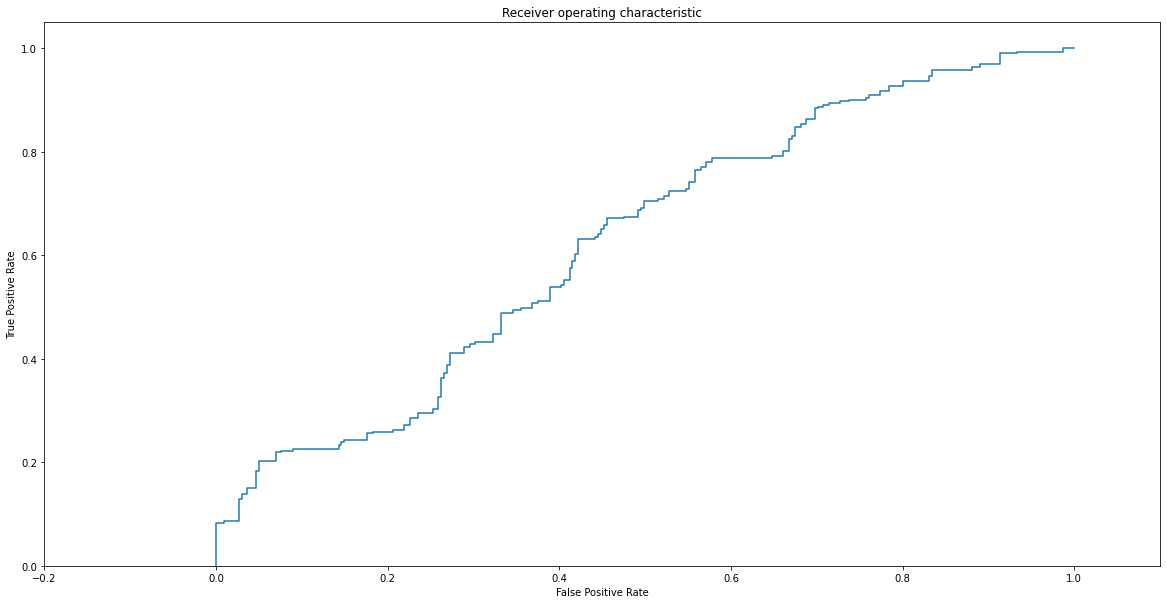

In [19]:
fpr = dict()
tpr = dict()
roc_auc = dict()
# print(clf.score(x_train, y_train, sample_weight=None))
# print(probs)
for i in range(2):
    fpr[i], tpr[i], _ =  roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(20,10))
#plt.plot(fpr[1], tpr[1])
plt.plot(fpr[1], tpr[1])
plt.xlim([-0.2, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [265]:
#imports for decision trees
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [279]:

rates = [0.1,0.2,0.3,0.4,0.5]

x = 0.1

acc = []
offset = []
gain = []
stuck = []
out_bounds = []
classification = []

# train_data = data[0:2640]
# test_data = data[2640:4000]

supply_temp_train = train_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)
stuck_val = random.randint(16,32)

FaultData, classification = simulateFault(supply_temp_train['supply_temp'],{'constant': 3, 'coeff': 1.2, 'stuck': stuck_val, 'bounds': [14,48]})
#print(classification)
supply_temp_train['supply_temp_BMS'] = FaultData
#supply_temp_train['classification'] = classification
supply_temp_train['lag_1'] = supply_temp_train['supply_temp'].shift(1)
supply_temp_train['lag_2'] = supply_temp_train['supply_temp_BMS'].shift(1)
supply_temp_train['lag_3'] = supply_temp_train['supply_temp'].shift(2)
supply_temp_train['lag_4'] = supply_temp_train['supply_temp_BMS'].shift(2)
supply_temp_train['lag_5'] = supply_temp_train['supply_temp'].shift(3)
supply_temp_train['lag_6'] = supply_temp_train['supply_temp_BMS'].shift(3)
supply_temp_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
supply_temp_train = supply_temp_train.dropna()
x_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
y_train = classification[0:len(classification)-3]#supply_temp_train[['classification']]
#Create a svm Classifier
scores = ['precision', 'recall']

In [280]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(x_train)
#X_test_scale = scaler.transform(X_test)
X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train_scale, y_train, random_state=0)
#gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=100,max_features=5 )

In [281]:
learning_rates = [0.05, 0.1, 0.15, 0.25, 0.30, 0.35, 0.45, 0.5, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=50, learning_rate = learning_rate, max_features=5, random_state =10,loss='deviance',max_depth=3)
    gb.fit(X_train_sub, y_train_sub)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))

Learning rate:  0.05
Accuracy score (training): 0.991
Accuracy score (validation): 0.990
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.998
Learning rate:  0.15
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.998
Learning rate:  0.3
Accuracy score (training): 1.000
Accuracy score (validation): 0.998
Learning rate:  0.35
Accuracy score (training): 1.000
Accuracy score (validation): 0.998
Learning rate:  0.45
Accuracy score (training): 1.000
Accuracy score (validation): 0.998
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.65
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.7
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.8
Accur

In [282]:
while x <= 0.5:
    supply_temp_test = test_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)

    for i in range(1,6):
        if i == 1:
            stuck_val = random.choice(test_data1['supply_temp'])
            sim_test_data1, classification1= simulateFault(test_data1['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
            #print(test_data1)
        
        elif i == 2:
            stuck_val = random.choice(test_data2['supply_temp'])
            sim_test_data2, classification2= simulateFault(test_data2['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
        
        elif i == 3:
            stuck_val = random.choice(test_data3['supply_temp'])
            sim_test_data3, classification3 = simulateFault(test_data3['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
        
        elif i == 4:
            stuck_val = random.choice(test_data4['supply_temp'])
            sim_test_data4, classification4 = simulateFault(test_data4['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
        
        elif i == 5:
            stuck_val = random.choice(test_data5['supply_temp'])
            sim_test_data5, classification5 = simulateFault(test_data5['supply_temp'],{'constant': 3, 'coeff': 1.5, 'stuck': stuck_val, 'bounds': [14,48]})
    
    FaultData = np.concatenate([sim_test_data1,sim_test_data2,sim_test_data3,sim_test_data4,sim_test_data5])#test_data1.append(test_data2)
    # FaultData = np.concatenate(FaultData,[test_data3])
    # FaultData = np.concatenate([FaultData,test_data4])
    # FaultData = np.concatenate([FaultData,test_data5])
    classification = np.concatenate([classification1,classification2,classification3,classification4,classification5])
    supply_temp_test['supply_temp_BMS'] = FaultData
    #supply_temp_test['classification'] = classification[2:len(classification)]
    supply_temp_test['lag_1'] = supply_temp_test['supply_temp'].shift(1)
    supply_temp_test['lag_2'] = supply_temp_test['supply_temp_BMS'].shift(1)
    supply_temp_test['lag_3'] = supply_temp_test['supply_temp'].shift(2)
    supply_temp_test['lag_4'] = supply_temp_test['supply_temp_BMS'].shift(2)
    supply_temp_test['lag_5'] = supply_temp_test['supply_temp'].shift(3)
    supply_temp_test['lag_6'] = supply_temp_test['supply_temp_BMS'].shift(3)
    supply_temp_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    supply_temp_test = supply_temp_test.dropna()
    x_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    y_test = classification[0:len(classification)-3]#supply_temp_test[['classification']]
    x_test = x_test.reset_index(drop=True)
    #print(x_test)
    # print(x_test[675:685])
    # print(y_test[675:685])
    #x_test = prepare_data(BMS, sensor_reading)
    x_test, y_test = sample_vectors(x_test, x)
    #print(vectors)
    #print(vectors)
    #x_test, y_test = process_data(vectors, [14,60])
    #print(x_test)
    #print(y_test)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    #print(y_test)
    X_test_transformed = scaler.transform(x_test)
    y_pred = gb.predict(X_test_transformed)
    #scores = cross_val_score(clf, np.concatenate((x_train, x_test), axis=0), np.concatenate((y_train, y_test), axis=0), cv=5)
    #print(scores)
    #target_names = ['No Fault', 'Offset', 'Gain', 'Stuck','Out of Bounds']
    
    target_names = ['class 0', 'class 1']
    #print('FOR rate: ',i)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=target_names))
    column_sum = cnf_matrix.sum(axis = 1)
    #print(column_sum)
    acc.append(cnf_matrix[1][1] / column_sum[1])
    # offset.append(cnf_matrix[1][1] / column_sum[1] )
    # gain.append(cnf_matrix[2][2] / column_sum[2])
    # stuck.append(cnf_matrix[3][3] / column_sum[3])
    # out_bounds.append(cnf_matrix[3][3] / column_sum[3])
        
    #print(acc)
    x = x + 0.1 
    
y_score = gb.decision_function(X_test_transformed)



              precision    recall  f1-score   support

     class 0       0.93      0.74      0.82       542
     class 1       0.17      0.47      0.25        60

    accuracy                           0.72       602
   macro avg       0.55      0.61      0.54       602
weighted avg       0.85      0.72      0.77       602

              precision    recall  f1-score   support

     class 0       0.82      0.72      0.77       482
     class 1       0.24      0.35      0.28       120

    accuracy                           0.65       602
   macro avg       0.53      0.53      0.52       602
weighted avg       0.70      0.65      0.67       602

              precision    recall  f1-score   support

     class 0       0.77      0.72      0.74       422
     class 1       0.42      0.49      0.45       180

    accuracy                           0.65       602
   macro avg       0.59      0.60      0.60       602
weighted avg       0.66      0.65      0.65       602

              preci

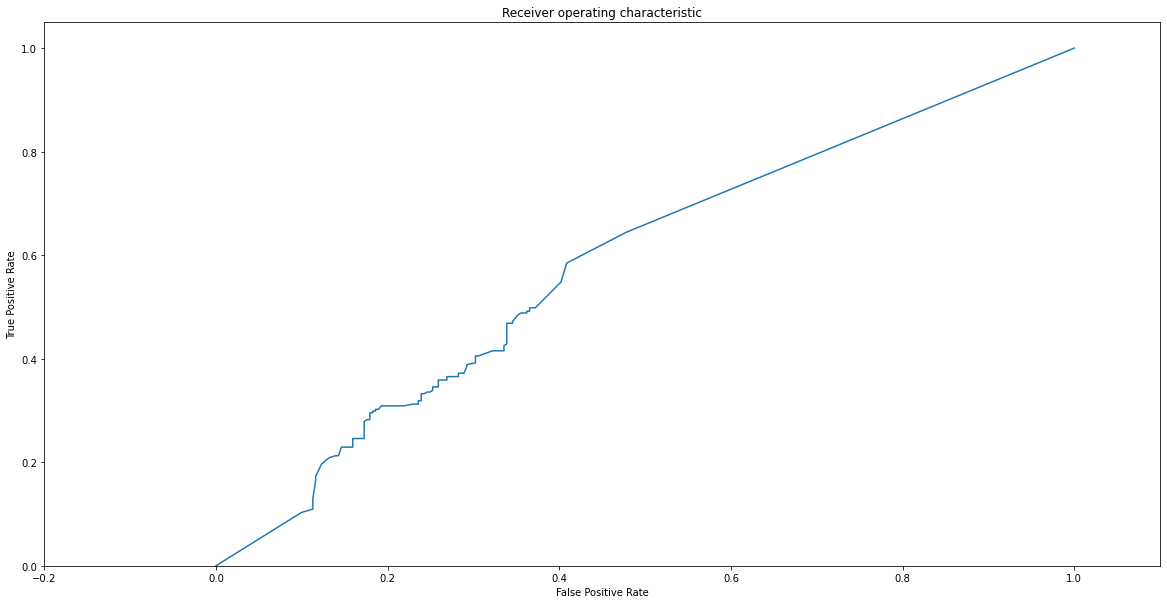

In [283]:
fpr = dict()
tpr = dict()
roc_auc = dict()
# print(clf.score(x_train, y_train, sample_weight=None))
# print(probs)
for i in range(2):
    fpr[i], tpr[i], _ =  roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(20,10))
#plt.plot(fpr[1], tpr[1])
plt.plot(fpr[1], tpr[1])
plt.xlim([-0.2, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()